# User-Based Collaborative Filtering

In [ ]:
import pandas as pd
import numpy as np
import time
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## Data Loading and Preprocessing

In [2]:
df = pd.read_csv('../data/ml-100k/ratings.csv')
print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(df.head())


Dataset shape: (100836, 4)
Columns: ['userId', 'movieId', 'rating', 'timestamp']
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931


Number of users: 610
Number of items: 9724
Number of ratings: 100836
Rating range: 0.5 - 5.0
Average rating: 3.50
Sparsity: 98.30%


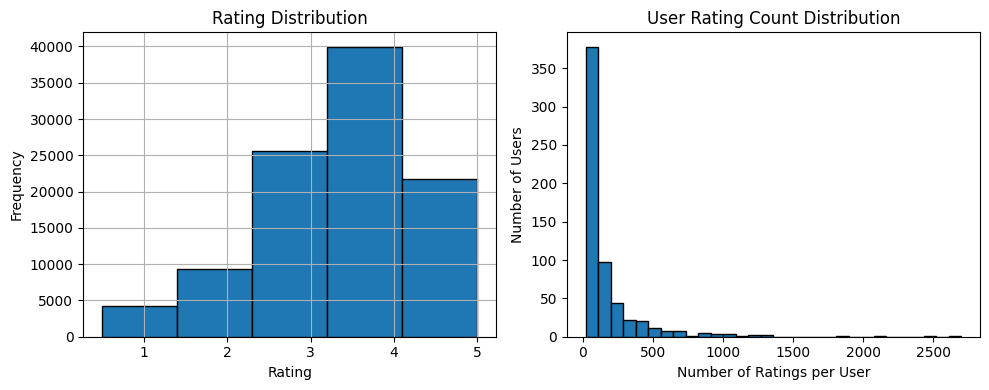

In [3]:
df = df.rename(columns={'userId': 'user_id', 'movieId': 'item_id'})

# Dataset statistics
print(f"Number of users: {df['user_id'].nunique()}")
print(f"Number of items: {df['item_id'].nunique()}")
print(f"Number of ratings: {len(df)}")
print(f"Rating range: {df['rating'].min()} - {df['rating'].max()}")
print(f"Average rating: {df['rating'].mean():.2f}")
print(f"Sparsity: {(1 - len(df) / (df['user_id'].nunique() * df['item_id'].nunique())) * 100:.2f}%")

# Rating distribution
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
df['rating'].hist(bins=5, edgecolor='black')
plt.title('Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
user_rating_counts = df['user_id'].value_counts()
plt.hist(user_rating_counts, bins=30, edgecolor='black')
plt.title('User Rating Count Distribution')
plt.xlabel('Number of Ratings per User')
plt.ylabel('Number of Users')
plt.tight_layout()
plt.show()

## User-Item Matrix Creation

In [4]:

user_item_matrix = df.pivot_table(
    index='user_id', 
    columns='item_id', 
    values='rating', 
    fill_value=0
)
print(user_item_matrix.shape)

print(f"User-item matrix shape: {user_item_matrix.shape}")

sparse_matrix = csr_matrix(user_item_matrix.values)
print(f"Sparse matrix density: {sparse_matrix.nnz / (sparse_matrix.shape[0] * sparse_matrix.shape[1]) * 100:.2f}%")

(610, 9724)
User-item matrix shape: (610, 9724)
Sparse matrix density: 1.70%


## Normalize User Ratings Function

In [5]:
def normalize_user_ratings(df):
    user_means = df.replace(0, np.nan).mean(axis=1).fillna(0)
    normalized = df.sub(user_means, axis=0).where(df > 0, 0)
    return normalized, user_means

## User Similarity Calculation 

In [6]:
def calculate_user_similarity(user_item_matrix):    
    # user mean ratings 
    user_mean_ratings = user_item_matrix.replace(0, np.nan).mean(axis=1).fillna(0).values
    similarity_matrix = cosine_similarity(user_item_matrix.values)
    return similarity_matrix, user_mean_ratings

In [7]:
def top_k_similar_users(similarity_matrix, k=50, similarity_threshold=0.1):
    n_users = similarity_matrix.shape[0]
    print(f"Finding top similar users from {n_users}² = {n_users**2:,} similarity pairs")
    
    user_similarities = {}
    for i in range(n_users):
        similar_users = []
        for j in range(n_users):
            if i != j and similarity_matrix[i][j] > similarity_threshold:
                similar_users.append((j, round(similarity_matrix[i][j], 3)))

        user_similarities[i] = sorted(similar_users, key=lambda x: x[1], reverse=True)[:k]

    return user_similarities

similarity_matrix = calculate_user_similarity(user_item_matrix)[0]
top_similar_users_for_user1 = top_k_similar_users(similarity_matrix, k=5, similarity_threshold=0.1)[1]
print(top_similar_users_for_user1)
    

Finding top similar users from 610² = 372,100 similarity pairs
[(365, np.float64(0.3)), (416, np.float64(0.28)), (377, np.float64(0.276)), (549, np.float64(0.254)), (188, np.float64(0.242))]


## Rating Prediction Function


In [8]:
def predict_rating(user_id, item_id, user_item_matrix, user_similarities, user_mean_ratings, top_k=20):
    if user_id not in user_item_matrix.index:
        return user_mean_ratings.mean()
    
    user_idx = user_item_matrix.index.get_loc(user_id)
    
    if item_id not in user_item_matrix.columns:
        return user_mean_ratings[user_idx]
    
    item_idx = user_item_matrix.columns.get_loc(item_id)
    
    similar_users = user_similarities.get(user_idx, [])
    if not similar_users:
        return user_mean_ratings[user_idx]
    
    numerator = 0
    denominator = 0
    
    for similar_user_idx, similarity in similar_users[:top_k]:
        rating = user_item_matrix.iloc[similar_user_idx, item_idx]
        if rating > 0:
            numerator += similarity * rating
            denominator += abs(similarity)
    
    if denominator == 0:
        return user_mean_ratings[user_idx]
    
    predicted_rating = numerator / denominator
    return max(1, min(5, predicted_rating))


In [9]:
similarity_matrix = calculate_user_similarity(user_item_matrix)[0]
user_similarities = top_k_similar_users(similarity_matrix, k=50, similarity_threshold=0.1)
user_mean_ratings = user_item_matrix.replace(0, np.nan).mean(axis=1)

predicted = predict_rating(
    user_id=1,
    item_id=50,
    user_item_matrix=user_item_matrix,
    user_similarities=user_similarities,
    user_mean_ratings=user_mean_ratings,
    top_k=20
)
print(f"Predicted rating for user 1 on item 50: {predicted:.2f}")


Finding top similar users from 610² = 372,100 similarity pairs
Predicted rating for user 1 on item 50: 4.34


## Recommendation Generation Function


In [10]:
def get_recommendations(user_id, user_item_matrix, user_similarities, user_mean_ratings, n_recommendations=10, top_k=20):
    if user_id not in user_item_matrix.index:
        print(f"User {user_id} not found!")
        return []

    user_pos = user_item_matrix.index.get_loc(user_id)
    user_row = user_item_matrix.iloc[user_pos]

    unrated_items = user_row[user_row == 0].index

    movies_df = pd.read_csv('../data/ml-100k/movies.csv')
    if 'movieId' in movies_df.columns:
        movie_map = dict(zip(movies_df['movieId'], movies_df['title']))
    else:
        movie_map = dict(zip(movies_df['item_id'], movies_df['title']))

    preds = []
    for item_label in unrated_items:
        pred = predict_rating(user_id, item_label, user_item_matrix, user_similarities, user_mean_ratings, top_k=top_k)
        movie_name = movie_map.get(item_label, str(item_label))
        preds.append((movie_name, pred))

    preds.sort(key=lambda x: x[1], reverse=True)
    return preds[:n_recommendations]

In [11]:
similarity_matrix, user_mean_ratings = calculate_user_similarity(user_item_matrix)
user_similarities = top_k_similar_users(similarity_matrix, k=50, similarity_threshold=0.1)

# get top-5 recommendations for user labeled 1
get_recommendations(1, user_item_matrix, user_similarities, user_mean_ratings, n_recommendations=5)


Finding top similar users from 610² = 372,100 similarity pairs


[('Eat Drink Man Woman (Yin shi nan nu) (1994)', 5),
 ("Nobody's Fool (1994)", 5),
 ('Mother Night (1996)', 5),
 ('Streetcar Named Desire, A (1951)', 5),
 ('Cinema Paradiso (Nuovo cinema Paradiso) (1989)', 5)]

Samples: 200, Time: 0.07s, MAE: 0.769, RMSE: 1.016


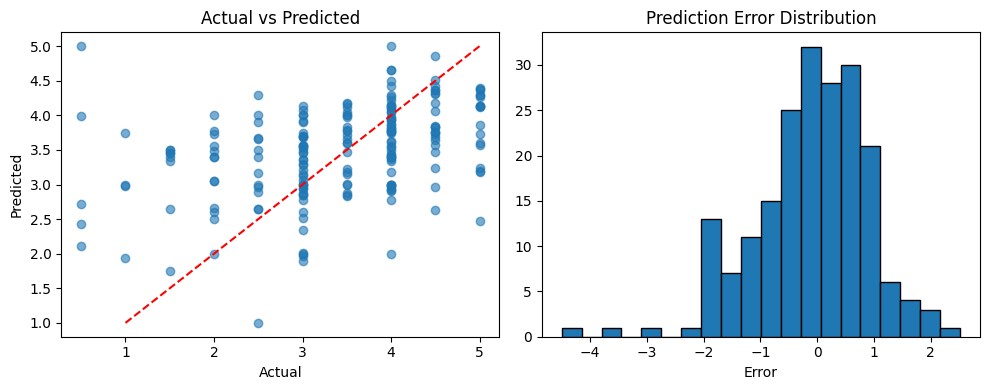

In [12]:
# Sample 200 user-item pairs
sample_data = df.sample(200, random_state=42)
actual = []
predicted = []

start = time.time()
for _, row in sample_data.iterrows():
    u, i, r = row['user_id'], row['item_id'], row['rating']
    if u in user_item_matrix.index and i in user_item_matrix.columns:
        actual.append(r)
        predicted.append(predict_rating(u, i, user_item_matrix, user_similarities, user_mean_ratings))
elapsed = time.time() - start

mae = np.mean(np.abs(np.array(actual) - np.array(predicted)))
rmse = np.sqrt(np.mean((np.array(actual) - np.array(predicted)) ** 2))
print(f"Samples: {len(actual)}, Time: {elapsed:.2f}s, MAE: {mae:.3f}, RMSE: {rmse:.3f}")

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.scatter(actual, predicted, alpha=0.6)
plt.plot([1, 5], [1, 5], 'r--')
plt.xlabel('Actual'); plt.ylabel('Predicted'); plt.title('Actual vs Predicted')
plt.subplot(1, 2, 2)
plt.hist(np.array(actual) - np.array(predicted), bins=20, edgecolor='black')
plt.xlabel('Error'); plt.title('Prediction Error Distribution')
plt.tight_layout()
plt.show()